In [ ]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
import torch
from torch import nn
from torch.nn import functional as F
from abc import abstractmethod

Tensor = TypeVar('torch.tensor')
class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise RuntimeWarning()

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

    
class VanillaVAE(BaseVAE):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.in_channels = in_channels
        

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], 
                                      out_channels=self.in_channels,
                                      kernel_size= 3, padding=1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        print("hh")
        mu, log_var = self.encode(input)
        print("hh")
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [ ]:
import math
import torch
from torch import optim
import pytorch_lightning as pl
from torchvision import transforms
import torchvision.utils as vutils
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader

def data_loader(fn):
    """
    Decorator to handle the deprecation of data_loader from 0.7
    :param fn: User defined data loader function
    :return: A wrapper for the data_loader function
    """

    def func_wrapper(self):
        try: # Works for version 0.6.0
            return pl.data_loader(fn)(self)

        except: # Works for version > 0.6.0
            return fn(self)

    return func_wrapper

class VAEXperiment(pl.LightningModule):

    def __init__(self,
                 vae_model: BaseVAE,
                 params: dict) -> None:
        super(VAEXperiment, self).__init__()

        self.model = vae_model
        self.params = params
        self.curr_device = None
        self.hold_graph = False
        try:
            self.hold_graph = self.params['retain_first_backpass']
        except:
            pass

    def forward(self, input: Tensor, **kwargs) -> Tensor:
        return self.model(input, **kwargs)

    def training_step(self, batch, batch_idx, optimizer_idx = 0):
        real_img, labels = batch
        self.curr_device = real_img.device

        results = self.forward(real_img, labels = labels)
        train_loss = self.model.loss_function(*results,
                                              M_N = self.params['batch_size']/ self.num_train_imgs,
                                              optimizer_idx=optimizer_idx,
                                              batch_idx = batch_idx)

        self.logger.experiment.log({key: val.item() for key, val in train_loss.items()})

        return train_loss

    def validation_step(self, batch, batch_idx, optimizer_idx = 0):
        real_img, labels = batch
        self.curr_device = real_img.device

        results = self.forward(real_img, labels = labels)
        val_loss = self.model.loss_function(*results,
                                            M_N = self.params['batch_size']/ self.num_val_imgs,
                                            optimizer_idx = optimizer_idx,
                                            batch_idx = batch_idx)

        return val_loss

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        tensorboard_logs = {'avg_val_loss': avg_loss}
        self.sample_images()
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

    def sample_images(self):
        # Get sample reconstruction image
        test_input, test_label = next(iter(self.sample_dataloader))
        test_input = test_input.to(self.curr_device)
        test_label = test_label.to(self.curr_device)
        recons = self.model.generate(test_input, labels = test_label)
        vutils.save_image(recons.data,
                          f"{self.logger.save_dir}{self.logger.name}/version_{self.logger.version}/"
                          f"recons_{self.logger.name}_{self.current_epoch}.png",
                          normalize=True,
                          nrow=12)

        # vutils.save_image(test_input.data,
        #                   f"{self.logger.save_dir}{self.logger.name}/version_{self.logger.version}/"
        #                   f"real_img_{self.logger.name}_{self.current_epoch}.png",
        #                   normalize=True,
        #                   nrow=12)

        try:
            samples = self.model.sample(144,
                                        self.curr_device,
                                        labels = test_label)
            vutils.save_image(samples.cpu().data,
                              f"{self.logger.save_dir}{self.logger.name}/version_{self.logger.version}/"
                              f"{self.logger.name}_{self.current_epoch}.png",
                              normalize=True,
                              nrow=12)
        except:
            pass


        del test_input, recons #, samples


    def configure_optimizers(self):

        optims = []
        scheds = []

        optimizer = optim.Adam(self.model.parameters(),
                               lr=self.params['LR'],
                               weight_decay=self.params['weight_decay'])
        optims.append(optimizer)
        # Check if more than 1 optimizer is required (Used for adversarial training)
        try:
            if self.params['LR_2'] is not None:
                optimizer2 = optim.Adam(getattr(self.model,self.params['submodel']).parameters(),
                                        lr=self.params['LR_2'])
                optims.append(optimizer2)
        except:
            pass

        try:
            if self.params['scheduler_gamma'] is not None:
                scheduler = optim.lr_scheduler.ExponentialLR(optims[0],
                                                             gamma = self.params['scheduler_gamma'])
                scheds.append(scheduler)

                # Check if another scheduler is required for the second optimizer
                try:
                    if self.params['scheduler_gamma_2'] is not None:
                        scheduler2 = optim.lr_scheduler.ExponentialLR(optims[1],
                                                                      gamma = self.params['scheduler_gamma_2'])
                        scheds.append(scheduler2)
                except:
                    pass
                return optims, scheds
        except:
            return optims

    @data_loader
    def train_dataloader(self):
        transform = self.data_transforms()

        if self.params['dataset'] == 'celeba':
            dataset = CelebA(root = self.params['data_path'],
                             split = "train",
                             transform=transform,
                             download=False)
        else:
            raise ValueError('Undefined dataset type')

        self.num_train_imgs = len(dataset)
        return DataLoader(dataset,
                          batch_size= self.params['batch_size'],
                          shuffle = True,
                          drop_last=True)

    @data_loader
    def val_dataloader(self):
        transform = self.data_transforms()

        if self.params['dataset'] == 'celeba':
            self.sample_dataloader =  DataLoader(CelebA(root = self.params['data_path'],
                                                        split = "test",
                                                        transform=transform,
                                                        download=False),
                                                 batch_size= 144,
                                                 shuffle = True,
                                                 drop_last=True)
            self.num_val_imgs = len(self.sample_dataloader)
        else:
            raise ValueError('Undefined dataset type')

        return self.sample_dataloader

    def data_transforms(self):

        SetRange = transforms.Lambda(lambda X: 2 * X - 1.)
        SetScale = transforms.Lambda(lambda X: X/X.sum(0).expand_as(X))

        if self.params['dataset'] == 'celeba':
            transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.CenterCrop(148),
                                            transforms.Resize(self.params['img_size']),
                                            transforms.ToTensor(),
                                            SetRange])
        else:
            raise ValueError('Undefined dataset type')
        return transform


# MY VAE

In [1]:
# Data
import h5py
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import os 
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from typing import List, Callable, Union, Any, TypeVar, Tuple
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Tensor = TypeVar('torch.tensor')

HOME_DIR = os.path.expanduser("~")
DATA_DIR = os.path.join(HOME_DIR, "data", "ocean", "ZZ")
ori_fname = os.path.join(DATA_DIR, "Filament000_00_CheltonEddy80percent_SSHA_Chl.mat")

fname = os.path.join(DATA_DIR, "Chl.h5")
fname_small = os.path.join(DATA_DIR, "Chl_small.h5")


if os.path.exists(fname):
    print(f"Loading data from\n\t{fname}")
else:
    print(f"Converting data")
    f_src = h5py.File(ori_fname, "r")
    d_src = f_src["E_logChl"]
    n = d_src.shape[2]
    f = h5py.File(fname, 'w')
    d = f.create_dataset(
        "E_logChl", (n, 100, 100),
        compression='gzip', 
        compression_opts=4,
        chunks=(4, 100, 100))
    tq = tqdm(range(n))
    for i in tq:
        d[i, ...] = d_src[:, :, i][...]
    f.close()
    
if os.path.exists(fname_small):
    print(f"Loading data from\n\t{fname_small}")
else:
    print(f"Converting data")
    f_src = h5py.File(ori_fname, "r")
    d_src = f_src["E_logChl"]
    n = 100
    f = h5py.File(fname_small, 'w')
    d = f.create_dataset(
        "E_logChl", (n, 100, 100),
        compression='gzip', 
        compression_opts=4,
        chunks=(4, 100, 100))
    tq = tqdm(range(n))
    for i in tq:
        d[i, ...] = d_src[:, :, i][...]
    f.close()    


f = h5py.File(fname, "r")
d = f["E_logChl"]  
f_small = h5py.File(fname_small, "r")
d_small = f_small["E_logChl"]
g_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', g_device)

Loading data from
	/home/junli/data/ocean/ZZ/Chl.h5
Loading data from
	/home/junli/data/ocean/ZZ/Chl_small.h5
Using device: cuda


In [2]:
class SSHADataset(Dataset):
    def __init__(self, fname):
        super(SSHADataset, self).__init__()
        self.f = h5py.File(fname, "r")
        self.ssha = self.f["E_SSHA"]        
        
    def __len__(self):
        return self.ssha.shape[2]
    
    def __getitem__(self, idx):
        return self.ssha[:, :, idx].to(g_device)


class ChlDataset(Dataset):
    def __init__(self, fname, **kwargs):
        super(ChlDataset, self).__init__(**kwargs)
        self.f = h5py.File(fname, "r")
        self.data = self.f["E_logChl"]        
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        # get 
        chl = torch.Tensor(self.data[idx, :, :])[None, ...]
        mask = torch.isnan(chl)
        return chl.to(g_device), mask.to(g_device)

# data = SSHADataset(fname, transform=ToTensor())    
data = ChlDataset(fname)
data_loader = DataLoader(data, batch_size=16, shuffle=True)

In [ ]:
# check information about the data
for tmp in data_loader:
    break
print(type(tmp))
for _ in tmp:
    print(type(_), _.shape, _.dtype)

### SSHA-VAE Model

In [ ]:
x = torch.randn(7, 1, 20, 20).to(g_device)

class SSHAVAE(nn.Module):        
    def __init__(self):
        super(SSHAVAE, self).__init__()
        self.latent_dim = 64
        
        ## encoder
        # input 20 x 20
        conv_kwargs = dict(kernel_size=3, stride=2, padding=1)
        self.conv_lay1 = nn.Conv2d(in_channels= 1, out_channels=16, **conv_kwargs) # 10x10
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.conv_lay2 = nn.Conv2d(in_channels=16, out_channels=32, **conv_kwargs) # 5 x 5
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.conv_lay3 = nn.Conv2d(in_channels=32, out_channels=64, **conv_kwargs) # 3 x 3
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.conv_lay4 = nn.Conv2d(in_channels=64, out_channels=128, **conv_kwargs)# 2 x 2
        self.bn4 = nn.BatchNorm2d(num_features=128)
        
        # z-distribution
        self.fc_mu = nn.Linear(128*4, self.latent_dim)
        self.fc_var = nn.Linear(128*4, self.latent_dim)
        
        ## decoder
        deconv_kwargs = dict(kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_input = nn.Linear(self.latent_dim, 128*4)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.bn4d = nn.BatchNorm2d(num_features=64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.bn3d = nn.BatchNorm2d(num_features=32)
        self.deconv2 = nn.ConvTranspose2d(32, 16, **deconv_kwargs)
        self.bn2d = nn.BatchNorm2d(num_features=16)
        # final layer
        self.deconv1 = nn.ConvTranspose2d(16, 16, **deconv_kwargs)
        self.bn1d = nn.BatchNorm2d(num_features=16)
        self.out_conv = nn.Conv2d(16, out_channels=1, kernel_size=3, padding=1)
        
    def encode(self, x: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        tmp = F.leaky_relu(self.bn1(self.conv_lay1(x)))
        tmp = F.leaky_relu(self.bn2(self.conv_lay2(tmp)))
        tmp = F.leaky_relu(self.bn3(self.conv_lay3(tmp)))
        tmp = F.leaky_relu(self.bn4(self.conv_lay4(tmp)))
        
        feat = torch.flatten(tmp, start_dim=1)
        mu = self.fc_mu(feat)
        log_var = self.fc_var(feat)
        return [mu, log_var]  
    
    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        tmp = self.decoder_input(z)
        tmp = tmp.view(-1, 128, 2, 2)
        tmp = F.leaky_relu(self.bn4d(self.deconv4(tmp)))
        tmp = F.leaky_relu(self.bn3d(self.deconv3(tmp)))
        tmp = F.leaky_relu(self.bn2d(self.deconv2(tmp)))
        tmp = F.leaky_relu(self.bn1d(self.deconv1(tmp)))
        x_hat = torch.tanh(self.out_conv(tmp))
        return x_hat
                                       
    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
        
    def go_through(self):
        n = 10
        tmp = torch.rand(n, 1, 20, 20)
        
        print(tmp.shape)
        tmp = self.bn1(self.conv_lay1(tmp))
        print(tmp.shape)
        tmp = self.bn2(self.conv_lay2(tmp))
        print(tmp.shape)
        tmp = self.bn3(self.conv_lay3(tmp))
        print(tmp.shape)
        tmp = self.bn4(self.conv_lay4(tmp))
        print(tmp.shape)
        
        tmp = torch.flatten(tmp, start_dim=1)
        print(tmp.shape)
        tmp_mu = self.fc_mu(tmp)
        print(tmp_mu.shape)
        tmp_var = self.fc_var(tmp)
        print(tmp_var.shape)
        
        # decoding
        z = self.reparameterize(tmp_mu, tmp_var)
        print(f"z ~ N(0, 1) samples {z.shape}")
        
        tmp = self.decoder_input(z)
        print(f"decoder-input {tmp.shape}")
        tmp = tmp.view(-1, 128, 2, 2)
        print(f"decoder-input-reshaped {tmp.shape}")
        
        tmp = F.leaky_relu(self.bn4d(self.deconv4(tmp)))
        print(f"decoder-4 {tmp.shape}")
        tmp = F.leaky_relu(self.bn3d(self.deconv3(tmp)))
        print(f"decoder-3 {tmp.shape}")
        
        tmp = F.leaky_relu(self.bn2d(self.deconv2(tmp)))
        print(f"decoder-2 {tmp.shape}")
        tmp = F.leaky_relu(self.bn1d(self.deconv1(tmp)))
        print(f"decoder-1 {tmp.shape}")
        tmp = torch.tanh(self.out_conv(tmp))
        print(f"out {tmp.shape}")
        
        
        
    
        
        """
        Was 5 -> 3 -> 2
        Direct deconv: 2 -> 4 -> 8
        How to return from 2 -> 3 -> 5
        """
        
        
    def forward(self, x: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), x, mu, log_var]
    
    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}
    
    
    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim) # from N(0, 1) NOT any posterior !!
        # z = z.to(current_device)
        samples = self.decode(z)
        return samples

model = SSHAVAE().to(g_device)
x_hat, _, mu, log_var = model(x)
model.loss_function(*model(x), M_N=1)
# model.go_through()

# deconv_lay1 = nn.ConvTranspose2d(16,
#                                  1,
#                                  kernel_size=3,
#                                  stride = 2,
#                                  padding=1,
#                                  output_padding=1)

# x_hat = deconv_lay1(y)
# print("Model Output size:", y[0].size())
# print("Model Reconstruction size:", x_hat[0].size())

### Chlorophyllin Level VAE Model

In [ ]:
data = ChlDataset(fname)
data_loader = DataLoader(data, batch_size=16, shuffle=True)
torch.manual_seed(42)
for x, msk in data_loader:
    break
print(x[0, 0][:2, :3])

#### Experiment with conv and deconv sizes

In [ ]:
x1 = torch.masked_fill(x, msk, 0)

In [ ]:
kw = dict(kernel_size=3, stride=2, padding=1)
h = x1
conv_lay1 = nn.Conv2d(in_channels= 1, out_channels=16, **kw)
h = conv_lay1(h)
print(h.shape)
conv_lay2 = nn.Conv2d(in_channels=16, out_channels=32, **kw)
h = conv_lay2(h)
print(h.shape)
conv_lay3 = nn.Conv2d(in_channels=32, out_channels=64, **kw)
h = conv_lay3(h)
print(h.shape)
conv_lay4 = nn.Conv2d(in_channels=64, out_channels=128, **kw)
h = conv_lay4(h)
print(h.shape)
conv_lay5 = nn.Conv2d(in_channels=128, out_channels=256, **kw)
h = conv_lay5(h)
print(h.shape)
conv_lay6 = nn.Conv2d(in_channels=256, out_channels=512, **kw)
h = conv_lay6(h)
print(h.shape)

deconv6 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
h = deconv6(h)
print(h.shape)
deconv5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=0)
h = deconv5(h)
print(h.shape)
deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0)
h = deconv4(h)
print(h.shape)
deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0)
h = deconv3(h)
print(h.shape)
deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
h = deconv2(h)
print(h.shape)
deconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
h = deconv1(h)
print(h.shape)
out_conv = nn.Conv2d(16, out_channels=1, kernel_size=3, padding=1)
h = out_conv(h)
print(h.shape)

#### Model def

In [3]:
class ChlVAE(nn.Module):        
    def __init__(self):
        super(ChlVAE, self).__init__()
        self.latent_dim = 16
        
        ## encoder
        # input 20 x 20
        kw = dict(kernel_size=3, stride=2, padding=1)
        self.conv_lay1 = nn.Conv2d(in_channels= 1, out_channels=16, **kw) # 100 -> 50
        self.bn1 = nn.BatchNorm2d(16)
        self.conv_lay2 = nn.Conv2d(in_channels=16, out_channels=32, **kw) # -> 25
        self.bn2 = nn.BatchNorm2d(32)
        self.conv_lay3 = nn.Conv2d(in_channels=32, out_channels=64, **kw) # -> 13
        self.bn3 = nn.BatchNorm2d(64)
        self.conv_lay4 = nn.Conv2d(in_channels=64, out_channels=128, **kw) # -> 7
        self.bn4 = nn.BatchNorm2d(128)
        self.conv_lay5 = nn.Conv2d(in_channels=128, out_channels=256, **kw) # -> 4
        self.bn5 = nn.BatchNorm2d(256)
        self.conv_lay6 = nn.Conv2d(in_channels=256, out_channels=512, **kw) # -> 2
        self.bn6 = nn.BatchNorm2d(512)
        
        self.inner_fmap_dim = 512
        self.inner_fmap_size = 2
        self.feature_vec_dim = self.inner_fmap_dim * (self.inner_fmap_size ** 2)
        
        # z-distribution
        self.fc_mu = nn.Linear(self.feature_vec_dim, self.latent_dim)
        self.fc_var = nn.Linear(self.feature_vec_dim, self.latent_dim)
        
        ## decoder
        def get_kw(opad):
            return dict(kernel_size=3, stride=2, padding=1, output_padding=opad) 
        self.decoder_input = nn.Linear(self.latent_dim, self.feature_vec_dim)
        self.deconv6 = nn.ConvTranspose2d(512, 256, **get_kw(1)) # 2 -> 4
        self.bn6d = nn.BatchNorm2d(num_features=256)
        self.deconv5 = nn.ConvTranspose2d(256, 128, **get_kw(0)) # -> 7
        self.bn5d = nn.BatchNorm2d(num_features=128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, **get_kw(0)) # -> 13
        self.bn4d = nn.BatchNorm2d(num_features=64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, **get_kw(0)) # -> 25
        self.bn3d = nn.BatchNorm2d(num_features=32)
        self.deconv2 = nn.ConvTranspose2d(32, 16, **get_kw(1)) # -> 50
        self.bn2d = nn.BatchNorm2d(num_features=16)
        self.deconv1 = nn.ConvTranspose2d(16, 16, **get_kw(1)) # -> 100
        self.bn1d = nn.BatchNorm2d(num_features=16)
        self.out_conv = nn.Conv2d(16, out_channels=1, kernel_size=3, padding=1)
      
        
    def encode(self, x: Tensor, msk: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        tmp = F.leaky_relu(self.bn1(self.conv_lay1(torch.masked_fill(x, msk, 0))))
        tmp = F.leaky_relu(self.bn2(self.conv_lay2(tmp)))
        tmp = F.leaky_relu(self.bn3(self.conv_lay3(tmp)))
        tmp = F.leaky_relu(self.bn4(self.conv_lay4(tmp)))
        tmp = F.leaky_relu(self.bn5(self.conv_lay5(tmp)))
        tmp = F.leaky_relu(self.bn6(self.conv_lay6(tmp)))
        
        feat = torch.flatten(tmp, start_dim=1)
        mu = self.fc_mu(feat)
        log_var = self.fc_var(feat)
        return [mu, log_var]  
    
    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        tmp = self.decoder_input(z)
        sz = self.inner_fmap_size
        tmp = tmp.view(-1, self.inner_fmap_dim, sz, sz)
        tmp = F.leaky_relu(self.bn6d(self.deconv6(tmp)))
        tmp = F.leaky_relu(self.bn5d(self.deconv5(tmp)))
        tmp = F.leaky_relu(self.bn4d(self.deconv4(tmp)))
        tmp = F.leaky_relu(self.bn3d(self.deconv3(tmp)))
        tmp = F.leaky_relu(self.bn2d(self.deconv2(tmp)))
        tmp = F.leaky_relu(self.bn1d(self.deconv1(tmp)))
        x_hat = torch.tanh(self.out_conv(tmp))
        return x_hat
                                       
    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
        
        
    def forward(self, x: Tensor, msk: Tensor) -> List[Tensor]:
        mu, log_var = self.encode(x, msk)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), (x, msk), mu, log_var]
    
    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        x_in, msk = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        err = torch.masked_fill(recons - torch.masked_fill(x_in, msk, 0), msk, 0)
        recons_loss = (err ** 2).mean()

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), 
                                               dim=1), dim=0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}
    
    
    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim) # from N(0, 1) NOT any posterior !!
        z = z.to(current_device)
        samples = self.decode(z)
        return samples

model = ChlVAE().to(g_device)
print(model.loss_function(*model.forward(x, msk), M_N=1))


NameError: name 'x' is not defined

### Consider how to deal with conv and de-conv

In [ ]:
tmp = torch.rand(1, 1, 3, 3)
c1 = nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=1)
tmp2 = c1(tmp)


tmp2.data.fill_(0)
tmp2.data.view(-1)[0] = 1
tmp2.data.view(-1)[1] = 2
tmp2.data.view(-1)[2] = -1
tmp2.data.view(-1)[3] = -2
print(tmp2.shape)
print(tmp2)

# in conv-transposed, param understand inversely
# padding - this many lines in the BIG array will be considered as padding and removed
d1 = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=3, 
                        padding=1, output_padding=2, bias=False)
d1.weight.data.fill_(0)
for i in range(d1.weight.numel()):
    d1.weight.data.view(-1)[i] = i
tmp3 = d1(tmp2)
print(tmp3.shape)
print(d1.weight)
print(tmp2[0, 0])
print(tmp3[0,0])

d2 = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, 
                        padding=1, output_padding=0, bias=False)
tmp4 = d2(tmp3)
print(tmp4.shape)

# Initial Experiment

In [4]:
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam

In [5]:
data = ChlDataset(fname) # (fname)
data_loader = DataLoader(data, batch_size=10, shuffle=True)
torch.manual_seed(42)
model = ChlVAE().to(g_device)
# print(model.loss_function(*model.forward(x, msk), M_N=1))

In [ ]:
optim = Adam(model.parameters(), lr=1e-4)

In [ ]:
optim = Adam(model.parameters(), lr=1e-4)
batch_portion = data_loader.batch_size / len(data)
writer = SummaryWriter()
n_batch = 0

# init_save: make sure check point works and for warm start
to_save = {
    'epoch': 0,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optim.state_dict(),
    'loss': 9999
    }
torch.save(to_save, f'checkpoints/latest.pt')

for epoch in range(100):
    t = tqdm(data_loader)
    for x, msk in t:
        optim.zero_grad()
        result = model.loss_function(*model.forward(x, msk), M_N=batch_portion)
        result['loss'].backward()
        optim.step()
        l = result['loss'].item()
        recon_l = result['Reconstruction_Loss'].item()
        kld = result['KLD'].item()
        t.set_description(f"epoch {epoch} loss {l:.4f}, recon {recon_l:.4f} kld {kld:.4f}")
        
        writer.add_scalar('Loss/tot', l, n_batch)
        writer.add_scalar('Loss/recon', recon_l, n_batch)
        writer.add_scalar('Loss/kld', kld, n_batch)
        n_batch += 1
    to_save = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'loss': l
        }
    torch.save(to_save, f'checkpoints/latest.pt')
    if epoch % 10 == 0:
        torch.save(to_save, f'checkpoints/ckpt_{epoch:04d}.pt')

epoch 10 loss 0.0078, recon 0.0075 kld -14.6227:  72%|███████▏  | 35073/48978 [10:46<04:15, 54.43it/s]

In [7]:
model2 = ChlVAE().to(g_device)
checkpoint = torch.load('checkpoints/ckpt_0090.pt')
model2.load_state_dict(checkpoint['model_state_dict'])
model2 = model2.eval()

In [17]:
x_hat = model2.sample(64, g_device)
x_hat = x_hat.detach().cpu()


In [16]:
z = torch.randn(16, model2.latent_dim) 
z = z.to(g_device)
x_hat = model2.decode(z).detach().cpu()

In [18]:
x_hat2 = (x_hat - x_hat.min())/(x_hat.max() - x_hat.min())

In [19]:
x_hat2 /= x_hat2.std()

In [20]:
from torchvision.utils import make_grid

In [26]:
im = make_grid(x_hat2, nrow=8).permute(1, 2, 0)
im = im.mean(dim=2)

In [27]:
im.mean()

tensor(0.8354)

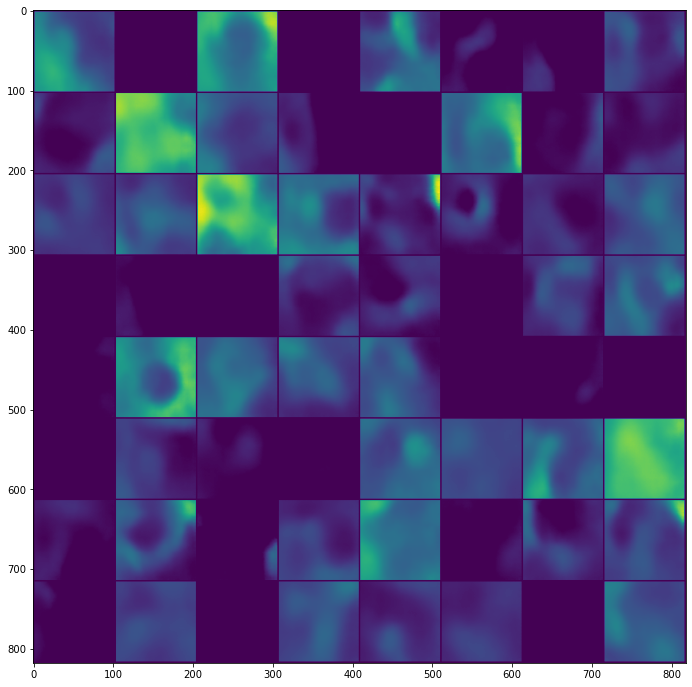

In [30]:
fig, ax0 = plt.subplots(figsize=(12, 12))
plt.imshow(im.numpy(), cmap='viridis')

# Formal Experiment

In [ ]:
import math
import torch
from torch import optim
import pytorch_lightning as pl
from torchvision import transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader

class VAEXperiment(pl.LightningModule):

    def __init__(self,
                 vae_model,
                 params: dict) -> None:
        super(VAEXperiment, self).__init__()

        self.model = vae_model
        self.params = params
        self.curr_device = None
        self.hold_graph = False
        self.num_train = 0
        self.num_val = 0
        try:
            self.hold_graph = self.params['retain_first_backpass']
        except:
            pass

    def forward(self, x: Tensor, **kwargs) -> Tensor:
        return self.model(x, **kwargs)

    def training_step(self, batch, batch_idx, optimizer_idx=0):
        data, msk = batch
        self.curr_device = data.device

        results = self.forward(data, msk=msk)
        # ChlVAE()

        train_loss = self.model.loss_function(
            *results,
            M_N = self.params['batch_size']/self.num_train,
            optimizer_idx=optimizer_idx,
            batch_idx=batch_idx)

        self.logger.experiment.log({key:val.item() 
                                    for key, val in train_loss.items()})

        return train_loss

    def validation_step(self, batch, batch_idx, optimizer_idx = 0):
        data, mask = batch
        self.curr_device = data.device

        results = self.forward(data, msk=msk)
        val_loss = self.model.loss_function(
            *results,
            M_N = self.params['batch_size']/self.num_val,
            optimizer_idx=optimizer_idx,
            batch_idx=batch_idx)

        return val_loss

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        tensorboard_logs = {'avg_val_loss': avg_loss}
        self.sample_images()
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

    def sample_images(self):
        # Get sample reconstruction image
        test_input, test_label = next(iter(self.sample_dataloader))
        test_input = test_input.to(self.curr_device)
        test_label = test_label.to(self.curr_device)
        recons = self.model.generate(test_input, labels = test_label)
        vutils.save_image(recons.data,
                          f"{self.logger.save_dir}{self.logger.name}/version_{self.logger.version}/"
                          f"recons_{self.logger.name}_{self.current_epoch}.png",
                          normalize=True,
                          nrow=12)

        try:
            samples = self.model.sample(144,
                                        self.curr_device,
                                        labels = test_label)
            vutils.save_image(samples.cpu().data,
                              f"{self.logger.save_dir}{self.logger.name}/version_{self.logger.version}/"
                              f"{self.logger.name}_{self.current_epoch}.png",
                              normalize=True,
                              nrow=12)
        except:
            pass


        del test_input, recons #, samples


    def configure_optimizers(self):
        optims = []
        scheds = []
        optimizer = optim.Adam(
            self.model.parameters(),
            lr=self.params['LR'],
            weight_decay=self.params['weight_decay'])
        optims.append(optimizer)
        # Check if more than 1 optimizer is required (Used for adversarial training)
        try:
            if self.params['LR_2'] is not None:
                optimizer2 = optim.Adam(
                    getattr(self.model, 
                            self.params['submodel']).parameters(),
                    lr=self.params['LR_2'])
                optims.append(optimizer2)
        except:
            pass

        try:
            if self.params['scheduler_gamma'] is not None:
                scheduler = optim.lr_scheduler.ExponentialLR(
                    optims[0],
                    gamma = self.params['scheduler_gamma'])
                scheds.append(scheduler)

                # Check if another scheduler is required for the second optimizer
                try:
                    if self.params['scheduler_gamma_2'] is not None:
                        scheduler2 = optim.lr_scheduler.ExponentialLR(
                            optims[1],
                            gamma = self.params['scheduler_gamma_2'])
                        scheds.append(scheduler2)
                except:
                    pass
                return optims, scheds
        except:
            return optims

    def train_dataloader(self):
        # transform = self.data_transforms()
        if self.params['dataset'] == 'chl':
            dataset = ChlDataset(self.params['data_path'], split="train")
        else:
            raise ValueError('Undefined dataset type')

        self.num_train = len(dataset)
        return DataLoader(dataset,
                          batch_size=self.params['batch_size'],
                          shuffle=True,
                          drop_last=True)

    def val_dataloader(self):
        # transform = self.data_transforms()
        if self.params['dataset'] == 'chl':
            dataset = ChlDataset(self.params['data_path'], split="test")
        else:
            raise ValueError('Undefined dataset type')

        self.num_val = len(dataset)
        return DataLoader(dataset,
                          batch_size=64,
                          shuffle=True,
                          drop_last=True)

        

    def data_transforms(self):
        SetRange = transforms.Lambda(lambda X: 2 * X - 1.)
        SetScale = transforms.Lambda(lambda X: X/X.sum(0).expand_as(X))

        if self.params['dataset'] == 'celeba':
            transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.CenterCrop(148),
                                            transforms.Resize(self.params['img_size']),
                                            transforms.ToTensor(),
                                            SetRange])
        else:
            raise ValueError('Undefined dataset type')
        return transform


In [ ]:
import yaml
config = yaml.safe_load("""
model_params:
  name: 'VanillaVAE'
  in_channels: 3
  latent_dim: 128

exp_params:
  dataset: chl
  data_path: '/Users/junli/data/ocean/ZZ/Filament000_00_CheltonEddy80percent_SSHA_Chl.mat'
  img_size: 100
  batch_size: 64 # Better to have a square number
  LR: 0.005
  weight_decay: 0.0
  scheduler_gamma: 0.95

trainer_params:
  gpus: 1
  max_nb_epochs: 50
  max_epochs: 30

logging_params:
  save_dir: "logs/"
  name: "VanillaVAE"
  manual_seed: 1265
""")

In [ ]:
config

# Ref

In [ ]:
import yaml
import argparse
import numpy as np
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TestTubeLogger

In [ ]:
config = yaml.safe_load(file)

In [ ]:
torch.manual_seed(123)
torch.randint(1000, (1,))